# V1: Pythonモデル構造可視化

学習済みPythonコード生成モデルの構造とパラメータ統計を可視化し、モデルの全体像を把握します。

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from model_analyzer import ModelAnalyzer, InferenceEngine

# Seabornのスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

import japanize_matplotlib  # 日本語表示を有効化


## ModelAnalyzerの初期化

In [2]:
# Pythonモデルの読み込み
analyzer = ModelAnalyzer('../model_python.json')

モデル読み込み完了: vocab_size=93, n_layer=1, n_embd=16, block_size=16, n_head=4


## セクション1：モデル設定情報

In [3]:
# モデル設定の表示
print("=" * 50)
print("Pythonモデル設定情報")
print("=" * 50)
print(f"語彙サイズ (vocab_size):       {analyzer.vocab_size}")
print(f"レイヤー数 (n_layer):           {analyzer.n_layer}")
print(f"埋め込み次元 (n_embd):          {analyzer.n_embd}")
print(f"コンテキスト長 (block_size):    {analyzer.block_size}")
print(f"ヘッド数 (n_head):              {analyzer.n_head}")
print(f"ヘッド次元 (head_dim):          {analyzer.head_dim}")

# パラメータ統計を取得
stats = analyzer.get_parameter_stats()
print(f"総パラメータ数:                 {stats['total_params']:,}")
print("=" * 50)

Pythonモデル設定情報
語彙サイズ (vocab_size):       93
レイヤー数 (n_layer):           1
埋め込み次元 (n_embd):          16
コンテキスト長 (block_size):    16
ヘッド数 (n_head):              4
ヘッド次元 (head_dim):          4
総パラメータ数:                 6,304


## セクション2：レイヤー別パラメータ数

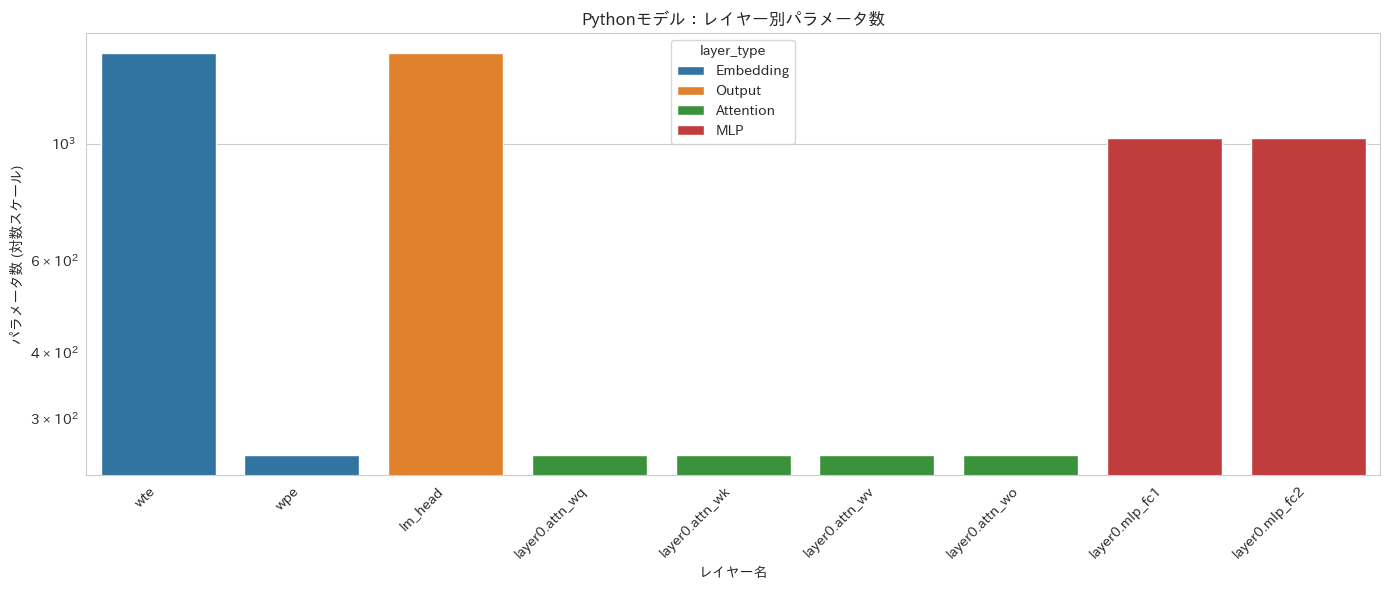


全体の総パラメータ数: 6,304


In [4]:
# レイヤー別パラメータ数のデータフレームを作成
params_data = []
for layer_name, count in stats['params_per_layer'].items():
    # レイヤーのタイプを判定
    if 'wte' in layer_name or 'wpe' in layer_name:
        layer_type = 'Embedding'
    elif 'attn' in layer_name:
        layer_type = 'Attention'
    elif 'mlp' in layer_name:
        layer_type = 'MLP'
    elif 'lm_head' in layer_name:
        layer_type = 'Output'
    else:
        layer_type = 'Other'
    
    params_data.append({
        'layer_name': layer_name,
        'param_count': count,
        'layer_type': layer_type
    })

params_df = pd.DataFrame(params_data)

# 棒グラフで可視化
plt.figure(figsize=(14, 6))
sns.barplot(data=params_df, x='layer_name', y='param_count', hue='layer_type', dodge=False)
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel('パラメータ数 (対数スケール)')
plt.xlabel('レイヤー名')
plt.title('Pythonモデル：レイヤー別パラメータ数')
plt.tight_layout()
plt.show()

print(f"\n全体の総パラメータ数: {stats['total_params']:,}")

## セクション3：重み行列の統計量

In [5]:
# 統計量のデータフレームを作成
stats_data = []
for layer_name, layer_stats in stats['stats_per_layer'].items():
    stats_data.append({
        '重み行列名': layer_name,
        '平均': layer_stats['mean'],
        '標準偏差': layer_stats['std'],
        '最小値': layer_stats['min'],
        '最大値': layer_stats['max']
    })

stats_df = pd.DataFrame(stats_data)

# DataFrameを表示（最大値を強調）
styled_df = stats_df.style.highlight_max(
    subset=['平均', '標準偏差', '最小値', '最大値'], 
    color='lightblue'
).format({
    '平均': '{:.6f}',
    '標準偏差': '{:.6f}',
    '最小値': '{:.6f}',
    '最大値': '{:.6f}'
})

display(styled_df)

,重み行列名,平均,標準偏差,最小値,最大値
0,wte,0.001380,0.195913,-0.809365,0.968240
1,wpe,-0.005292,0.132097,-0.616111,0.398498
2,lm_head,-0.001304,0.416807,-1.444526,1.339382
3,layer0.attn_wq,0.004954,0.221143,-0.496607,0.654145
4,layer0.attn_wk,0.000756,0.225630,-0.762129,0.616971
5,layer0.attn_wv,0.020731,0.190607,-0.454516,0.493624
6,layer0.attn_wo,0.011051,0.184036,-0.549692,0.428289
7,layer0.mlp_fc1,0.003143,0.166110,-0.515137,0.567930
8,layer0.mlp_fc2,0.007341,0.147212,-0.543986,0.571434


## セクション4：モデルアーキテクチャ図

```mermaid
graph TD
    A[入力トークン] --> B[Token Embedding]
    A --> C[Position Embedding]
    B --> D[埋め込みベクトル合成]
    C --> D
    D --> E[RMSNorm]
    E --> F[Multi-Head Attention]
    F --> G[Attention Output Linear]
    G --> H[Residual接続 1]
    D --> H
    H --> I[RMSNorm]
    I --> J[MLP: FC1]
    J --> K[ReLU]
    K --> L[MLP: FC2]
    L --> M[Residual接続 2]
    H --> M
    M --> N[LM Head Linear]
    N --> O[Softmax]
    O --> P[出力確率分布]
    
    style A fill:#e1f5ff
    style B fill:#fff4e1
    style C fill:#fff4e1
    style F fill:#ffe1e1
    style J fill:#e1ffe1
    style K fill:#e1ffe1
    style L fill:#e1ffe1
    style P fill:#f0e1ff
```

### アーキテクチャの説明

1. **Embedding層**: 入力トークン（Python文字・記号）をToken EmbeddingとPosition Embeddingに変換し、合成します
2. **Transformer Block**: 以下を繰り返します
   - RMSNorm → Multi-Head Attention → Residual接続
   - RMSNorm → MLP (FC1 → ReLU → FC2) → Residual接続
3. **LM Head**: 最終的な埋め込みベクトルを語彙サイズの次元に変換
4. **Softmax**: 次トークンの確率分布を計算

## まとめ

このNotebookでは、Pythonコード生成用microGPTモデルの構造を確認しました：

- Python文字・記号（アルファベット、数字、括弧、演算子等）を扱うTransformerモデル
- 各レイヤーのパラメータ数と統計量を可視化
- Embeddingレイヤーが最も多くのパラメータを持つ

次のNotebookでは、Pythonコード生成時のAttention機構の挙動を詳細に可視化します。